In [1]:
# General imports
import os
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table

# Grizli
import grizli
from grizli.model import GrismFLT
import pysynphot as S

os.chdir("/Users/keith/astr/research_astr/summer-roman-project/4) FOV0_sims/fits")
root = "GRS_FOV0_roll0_dx0_dy0_SCA1_direct_final.fits" # Change filename with this variable
direct_file = "ready_direct_{0}".format(root)
seg_file = "seg_{0}".format(root)

/Users/keith/miniconda3/envs/grizli-env/lib/python3.12/site-packages/pysynphot/locations.py:46: UserWarning: PYSYN_CDBS is undefined; functionality will be SEVERELY crippled.
  warnings.warn("PYSYN_CDBS is undefined; functionality will be SEVERELY "
/Users/keith/miniconda3/envs/grizli-env/lib/python3.12/site-packages/pysynphot/locations.py:345: UserWarning: Extinction files not found in extinction
  warnings.warn('Extinction files not found in %s' % (extdir, ))


In [2]:
# Identify objects of interest
tbl = Table.read("cat_GRS_FOV0_roll0_dx0_dy0_SCA1_direct_final.fits.detect.cat", format="ascii.ecsv")

# Ensure you are using rotated coordinates
coords = (abs(tbl["x_flt"] - 4040) < 5) & (abs(tbl["y_flt"] - 3770) < 10)
index = np.where(coords)

# index = np.where(tbl['id']==7195)

tbl[index].pprint_all()

 id        x_flt             y_flt        mag  hlss_id      distance        z              SED          
---- ----------------- ----------------- ----- ------- ----------------- -------- ----------------------
7132 4036.515246784876 3765.933941026709 20.41  2678.0 2.060589700997127 1.464803 SED:rest:gal.2678.fits


In [3]:
# Instantiate the GrismFLT object
pad = 100
roman_sim = GrismFLT(direct_file=direct_file, seg_file=seg_file, pad=pad)



Image cutout: x=slice(0, 4088, None), y=slice(0, 4088, None) [Out of range]
ready_direct_GRS_FOV0_roll0_dx0_dy0_SCA1_direct_final.fits / Pad ref HDU with 264 pixels
ready_direct_GRS_FOV0_roll0_dx0_dy0_SCA1_direct_final.fits / blot segmentation seg_GRS_FOV0_roll0_dx0_dy0_SCA1_direct_final.fits[0]
The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    
The following tasks in the drizzlepac package can be run with TEAL:
    astrodrizzle       config_testbed      imagefindpars           mapreg       
       photeq            pixreplace           pixtopix            pixtosky      
  refimagefindpars       resetbits          runastrodriz          skytopix      
     tweakback            tweakreg           updatenpol
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...


In [4]:
# Read in SED
from astropy.io import fits
SED_dir = "/Users/keith/astr/research_astr/FOV0/FOV0_SEDs"
specific_sed = tbl["SED"][index].value[0]

file = fits.open(os.path.join(SED_dir, specific_sed))
SED_data = file[1].data
file.close()

# Extract wavelength and flux
rest_wave = np.asarray([tuple[0] for tuple in SED_data])
# z = (10000 / rest_wave.min()) - 1
z = tbl['z'][index]
redshifted_wave = rest_wave * (z+1)
del rest_wave

flux = np.asarray([tuple[1] for tuple in SED_data])

In [5]:
# Compute Flat vs 1D Spectra
id, mag = tbl['id'][index].value[0], tbl['mag'][index].value[0]
print("Computing model order; id:{0} mag:{1}".format(id, mag))

roman_sim.compute_model_orders(id=id, mag=mag, compute_size=False, 
                               size=77, in_place=True, spectrum_1d=[redshifted_wave, flux])
model_orders = np.rot90(roman_sim.model[pad:-pad, pad:-pad])

flat_orders = np.rot90(roman_sim.compute_model_orders(id=id, mag=mag, 
                       compute_size=False, size=77, in_place=False)[1][pad:-pad, pad:-pad])

Computing model order; id:7132 mag:20.41


In [6]:
# load in wang et al
file = fits.open("/Users/keith/astr/research_astr/FOV0/slitless/GRS_FOV0_roll0_dx0_dy0_SCA1_slitless_final.fits")
data = file[1].data
file.close()

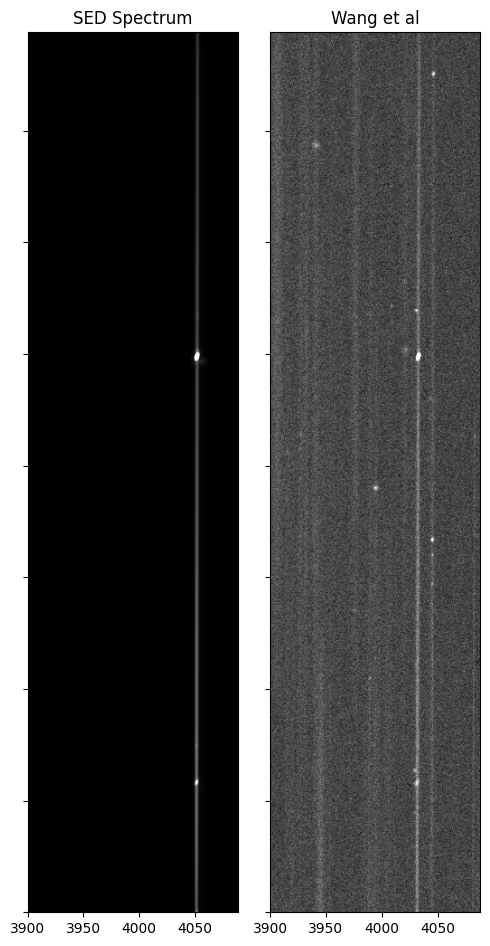

In [7]:
# Display comparison image
fig, (ax2, ax3) = plt.subplots(1, 2, figsize=(5,10))

ax2.imshow(model_orders, origin="lower", cmap='grey', vmax=np.max(model_orders)/5)
ax2.set_xlim(3900, 4088)
ax2.set_ylim(3300,4088)
ax2.set_title("SED Spectrum")
ax2.set_yticklabels([])

ax3.imshow(data, origin="lower", cmap='grey', vmax=np.max(data)/100)
ax3.set_xlim(3900, 4088)
ax3.set_ylim(3300,4088)
ax3.set_title("Wang et al")
ax3.set_yticklabels([])

fig.tight_layout()

In [8]:
print(np.min(model_orders),
np.max(model_orders),
np.mean(model_orders))

0.0 564.1983 0.0062603797


In [9]:
# Assume they're off by a scalar
data_max = np.argmax(data[200:400, 2500:4000])
model_max = np.argmax(model_orders[200:400, 2500:4000])

scalar = np.max(data[200:400, 2500:4000]) / np.max(model_orders[200:400, 2500:4000])
print(scalar)

inf


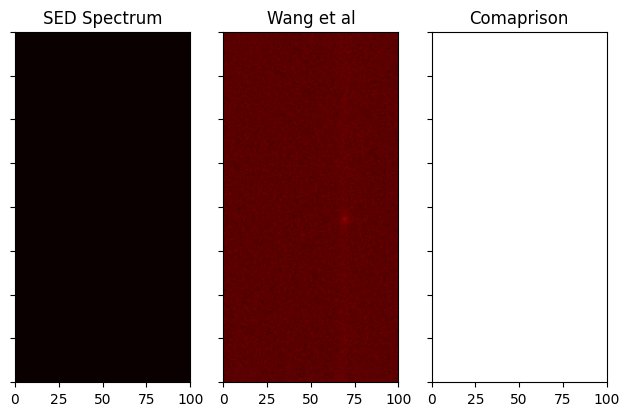

In [10]:
scaled_model = model_orders * scalar

# Display comparison image
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

ax1.imshow(model_orders, origin="lower", cmap='hot', vmax=np.max(model_orders)/5)
ax1.set_xlim(0, 100)
ax1.set_ylim(0, 200)
ax1.set_title("SED Spectrum")
ax1.set_yticklabels([])

ax2.imshow(data, origin="lower", cmap='hot', vmin=0, vmax=np.max(data)/25)
ax2.set_xlim(0, 100)
ax2.set_ylim(0, 200)
ax2.set_title("Wang et al")
ax2.set_yticklabels([])

ax3.imshow(data-scaled_model, origin="lower", cmap='hot', vmin=-np.max(scaled_model), vmax=np.max(data)/25)
ax3.set_xlim(0, 100)
ax3.set_ylim(0, 200)
ax3.set_title("Comaprison")
ax3.set_yticklabels([])

fig.tight_layout()